Here, we apply a Robust PCA (from `tensorly` package) to do video background subtraction on a surveillance video. The example is based on https://jeankossaifi.github.io/tensorly/rpca.html#Example-on-a-video.

We use the Tensorly's `mxnet` backend and try to use GPU/CUDA acceleration.

However, although the tensors reside in the GPU context, `robust_pca` seems to be computed on CPU without GPU acceleration.

Load packages

In [1]:
import numpy as np
import mxnet as mx
import tensorly as tl
tl.set_backend('mxnet')

Using numpy backend.
Using mxnet backend.


Show version

In [2]:
tl.__version__

'0.2.0'

In [3]:
mx.__version__

'0.11.0'

Download surveillance video

In [4]:
video_filename = 'campus.avi'
import os
if not os.path.exists(video_filename):
    from urllib.request import urlretrieve
    urlretrieve ("http://cvrr.ucsd.edu/aton/shadow/data/campus_raw.AVI", video_filename)

Read video as numpy array

In [5]:
# read AVI
import imageio
data = imageio.mimread(video_filename, memtest=False)

# convert from RGB to greyscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
data = [rgb2gray(i) for i in data]

# resize images
from skimage.transform import resize
def imresize(image):
    return resize(image, output_shape=(image.shape[0]*0.5, image.shape[0]*0.5))
data = [imresize(i) for i in data]

# list -> array
data = np.array(data, np.uint8)
print("shape = ", data.shape)
print("dtype = ", data.dtype)

/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


shape =  (1179, 144, 144)
dtype =  uint8


Select few frames (30...50)

In [6]:
data = data[30:50]

Show a few frames

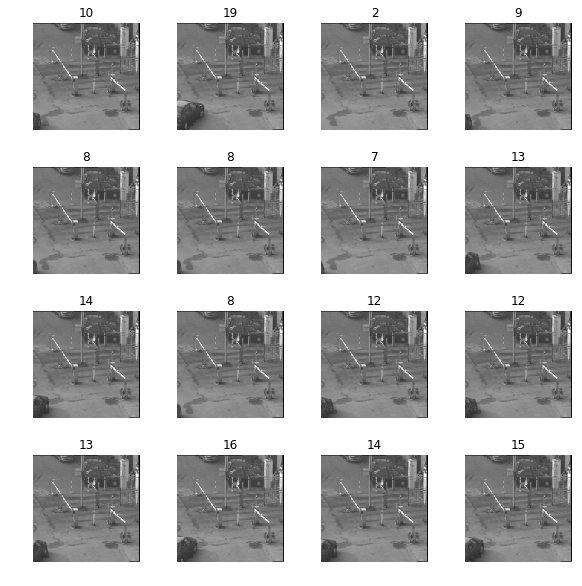

In [7]:
%matplotlib inline
import matplotlib.pylab as plt
fig, ax = plt.subplots(4,4,figsize=(8,8))
ax = ax.flatten()
fig.tight_layout(pad=0)
for i in range(16):
    sample = np.random.choice( range(data.shape[0]) )
    ax[i].imshow(data[sample], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(sample)

Load data into tensorly variable

- Note: we supply the context `ctx=mx.gpu()` to enable running on GPU 

In [8]:
X = tl.tensor(data, ctx=mx.gpu()) # <- GPU context 
X = X.astype(np.float32)
tl.context(X)

{'ctx': gpu(0), 'dtype': numpy.float32}

Apply Robust PCA to subtract background (`low_rank_part, D`) from foreground (`sparse_part, E`)

Unfortunately, the function `tensorly.decomposition.robust_pca` does **not** seem to be accelerated on GPU.

In the following snippet, the tensor `X` lives in a GPU context (as shown in cell above). The internal tensors (`D`,`E`,`L_x`,`J` and `L`) inherit this context (as shown below). Also, the outputs are in GPU context. Nevertheless, the computations seem to be done on CPU instead of GPU (as judged by CPU/GPU usage stats).

In [9]:
from tensorly.decomposition import robust_pca
D, E = robust_pca(X, reg_E=0.05, learning_rate=1.6, n_iter_max=20)

context X: {'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}
context D: {'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}
context E: {'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}
context L_x: {'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}
context J[0]: {'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}
context L[0]: {'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}
.iteration 0, error X: 59157.242, error D: 19719.078
.iteration 1, error X: 40220.262, error D: 13720.569
.iteration 2, error X: 21700.738, error D: 7993.424
.iteration 3, error X: 8657.425, error D: 3732.384
.iteration 4, error X: 5266.908, error D: 2365.496
.iteration 5, error X: 6402.552, error D: 2458.428
.iteration 6, error X: 5703.294, error D: 2163.860
.iteration 7, error X: 3935.222, error D: 1571.911
.iteration 8, error X: 2170.295, error D: 959.033
.iteration 9, error X: 934.524, error D: 532.360
.iteration 10, error X: 411.763, error D: 300.491
.iteration 11, error X: 323.672, error D: 196.386
.iteration 12,

In [10]:
print(tl.context(X))
print(tl.context(D))
print(tl.context(E))

{'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}
{'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}
{'ctx': gpu(0), 'dtype': <class 'numpy.float32'>}


Visualize results

In [11]:
def visualise_rpca(X, low_rank_part, sparse_part, n_images=20):
    """A little helper function to visualise the result of tensor RPCA
    """
    indices = np.arange(X.shape[0])
    #np.random.shuffle(indices)
    indices = indices[:n_images]

    fig = plt.figure(figsize=(10, 2*n_images))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i, e in enumerate(indices):
        cmap = plt.cm.Greys_r

        ax = fig.add_subplot(n_images, 4, 4*i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Original')

        ax = fig.add_subplot(n_images, 4, 4*i + 2, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Low-rank')

        ax = fig.add_subplot(n_images, 4, 4*i + 3, xticks=[], yticks=[])
        ax.imshow(sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Sparse')

        ax = fig.add_subplot(n_images, 4, 4*i + 4, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e]+sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Reconstruction')

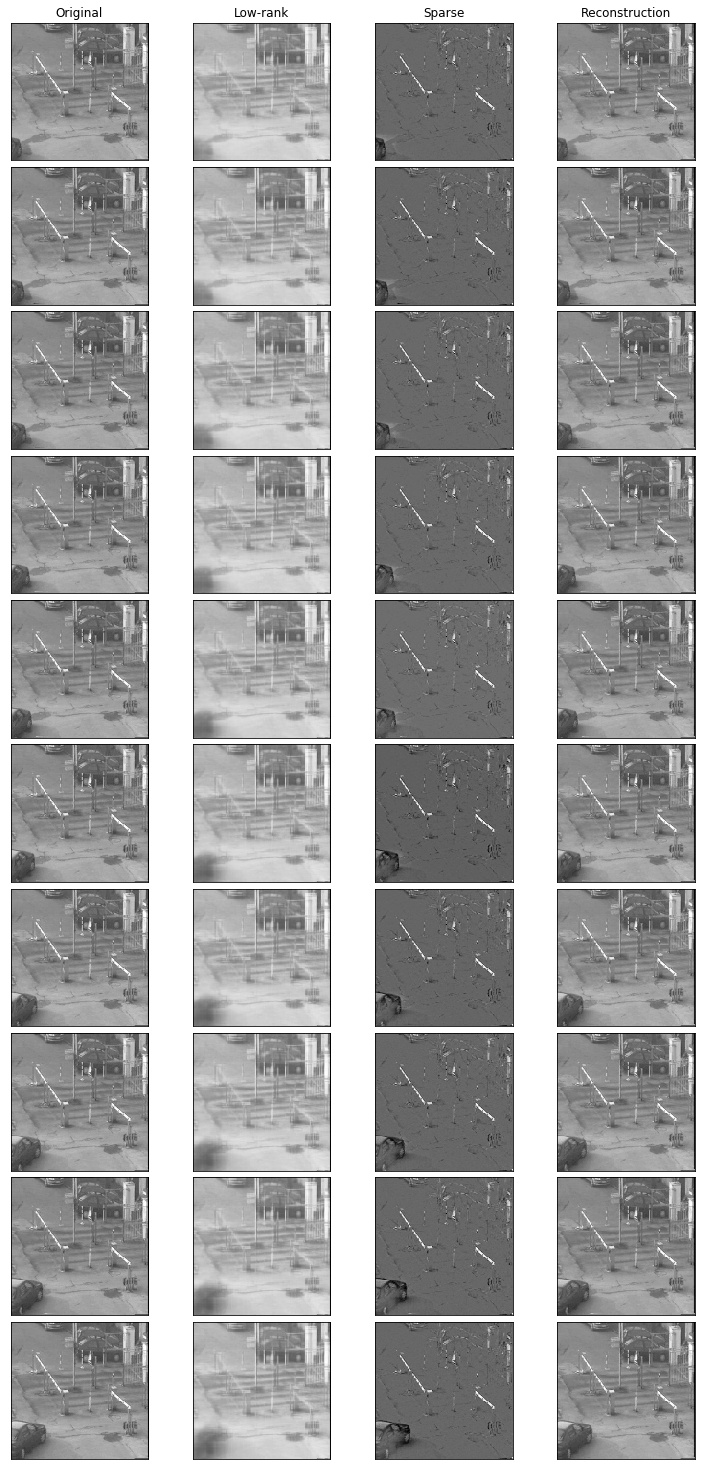

In [12]:
visualise_rpca(X[10:20].asnumpy(), D[10:20].asnumpy(), E[10:20].asnumpy(), n_images=20)


In [13]:
def to_uint8(x):
    return np.array((D*255.0), np.uint8)
    
import imageio
imageio.mimsave('X.mp4', to_uint8(X.asnumpy()), format='MP4', fps=4)
imageio.mimsave('D.mp4', to_uint8(D.asnumpy()), format='MP4', fps=4)
imageio.mimsave('E.mp4', to_uint8(E.asnumpy()), format='MP4', fps=4)
imageio.mimsave('R.mp4', to_uint8((D+E).asnumpy()), format='MP4', fps=4)

ValueError: setting an array element with a sequence.

Original
<p>
  <video width="200" height="240" controls autoplay loop src="./X.mp4" />
</p>

Reconstruction
<p>
 <video width="200" height="240" controls autoplay loop src="./R.mp4" />
</p>

Low rank
<p>
 <video width="200" height="240" controls autoplay loop src="./D.mp4" />
</p>

Sparse part
<p>
 <video width="200" height="240" controls autoplay loop src="./E.mp4" />
</p>

